# Biotuner Toolbox Paper Results Figures

In [105]:
from biotuner.biotuner_object import *
from biotuner.metrics import *
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from neurodsp.sim import sim_combined
from scipy.interpolate import make_interp_spline, BSpline
from biotuner.biotuner_utils import generate_signal
from biotuner.biotuner_object import compute_biotuner
import numpy as np

### Figure 2. Performance analysis of different peak extraction methods

In [ ]:
# Setting up parameters
sf = 1000
length = 4
n_times = 100 #number of times the bootstraping is executed
freqs = [2, 6, 12, 24]
amps = [1, 1, 1, 1]
FREQ_BANDS = [[1, 5], [5, 10], [10, 20], [20, 30]]

# Simulate the signals
components = {
    'sim_powerlaw': {'exponent': -1}, 
    'sim_oscillation': [{'freq': freq} for freq in freqs]  # list of dictionaries
}
component_variances = [1 for _ in range(len(freqs) + 1)]  # +1 for the 'sim_powerlaw' component

# Simulate original signal
simulated_EEG = sim_combined(length, sf, components, component_variances)

# Simulate EEG signal
simulated_oscillations = generate_signal(sf, length, freqs, amps, show=False, color = 'turquoise')  # Assuming generate_signal is your custom function

signals = {'Simulated Oscillations': simulated_oscillations, 'Simulated EEG Signal': simulated_EEG}

for title, signal in signals.items():
    peaks_methods = ['fixed', 'harmonic_recurrence', 'EIMC', 'EMD', 'FOOOF']
    noise_db_list = range(0, 40, 1)
    colors = ['darkred', 'darkblue', 'darkorange', 'black', 'cyan', 'deeppink']

    data = []
    for method, color in zip(peaks_methods, colors):
        print(method)
        median_distance_tot = []
        for db in noise_db_list: 
            t = 0
            median_distance = []
            while t < n_times:
                # Convert to linear Watt units
                target_noise_watts = 10 ** (db / 10)

                # Generate noise samples
                mean_noise = 0
                noise_signal = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(signal))
                # transform noise into pink noise
                

                # Noise up the original signal with pink noise
                noised_signal = signal + noise_signal
            
                # set dictionary of prominence and rel_height for each method
                prominences = {'fixed': 10, 'harmonic_recurrence': 6, 'EMD': 1, 'FOOOF': 10, 'HH1D_max': 1, 'EIMC': 7}
                rel_heights = {'fixed': 1, 'harmonic_recurrence': 1, 'EMD': 0.7, 'FOOOF': 1, 'HH1D_max': 1, 'EIMC': 1}
                # Initialize biotuner object
                biotuning = compute_biotuner(sf = sf, peaks_function=method, precision=0.5)
                
                if method == 'EMD':
                    biotuning.peaks_extraction(noised_signal, min_freq=1, max_freq=50, min_harms=2, harm_limit=128, 
                                        FREQ_BANDS = FREQ_BANDS, verbose=False, graph=False, prominence=prominences[method],
                                        rel_height=rel_heights[method], nIMFs=6, keep_first_IMF=False, n_peaks=6)
                    biotuning.peaks = biotuning.peaks[0:4] # select only the first 4 peaks
                    biotuning.peak = [x for x in biotuning.peaks if x <= freqs[-1]+1]
                    
                else:
                    
                    biotuning.peaks_extraction(noised_signal, min_freq=1, max_freq=50, min_harms=2, harm_limit=128, 
                                        FREQ_BANDS = FREQ_BANDS, verbose=False, graph=False, prominence=prominences[method],
                                        rel_height=rel_heights[method], nIMFs=3, keep_first_IMF=True, n_peaks=4)
                    biotuning.peaks = [x for x in biotuning.peaks if x <= freqs[-1]+1]

                if db == 0:
                    no_noise_peaks = biotuning.peaks
                if len(biotuning.peaks) == 0:
                    median_distance.append(np.nan)
                else:
                    list_distance = []
                    for p in biotuning.peaks:
                        takeClosest = lambda num,collection:min(collection,key=lambda x:abs(x-num))
                        closest = takeClosest(p,freqs)
                        list_distance.append(abs(p-closest))   
                    median_distance.append(np.nanmedian(list_distance))
                t += 1
            median_distance_tot.append(np.nanmedian(median_distance)) 
            # calculate standard deviation
            std_dev = np.nanstd(median_distance)
                    # Continue with your computations... 

            data.append([method, db, np.nanmedian(median_distance), np.nanstd(median_distance)])

    df = pd.DataFrame(data, columns=["Method", "Noise decibels", "Median distance", "Std deviation"])

    # Add the option for std or 95% CI
    error_option = 'CI'  # change to 'std' for standard deviation

    plt.figure(figsize=(6,4))
    for method in peaks_methods:
        df_method = df[df["Method"] == method]
        df_method = df_method[df_method['Std deviation'].notna()]
        
        # To create smooth line plot
        xnew = np.linspace(df_method["Noise decibels"].min(), df_method["Noise decibels"].max(), 300)
        spl = make_interp_spline(df_method["Noise decibels"], df_method["Median distance"], k=3)  # type: BSpline
        y_smooth = spl(xnew)
        
        if error_option == 'std':
            spl_std = make_interp_spline(df_method["Noise decibels"], df_method["Std deviation"], k=3)  # type: BSpline
            error_smooth = spl_std(xnew)
        elif error_option == 'CI':
            confidence_interval = df_method["Std deviation"] / np.sqrt(n_times) * 1.96
            spl_ci = make_interp_spline(df_method["Noise decibels"], confidence_interval, k=3)  # type: BSpline
            error_smooth = spl_ci(xnew)

        line, = plt.plot(xnew, y_smooth, label=method)  # use same color for the line
        # remove grid from plot
        plt.grid(False)
        color = line.get_color()  # get color of the line

        plt.fill_between(xnew, y_smooth-error_smooth, y_smooth+error_smooth, color=color, alpha=0.2)

    plt.title(title, size=16)
    plt.grid(False)
    plt.legend(loc="upper left", title="Peak Extraction Method")
    plt.xlabel("Noise decibels")
    plt.ylabel("Median distance from target frequency")
    plt.tight_layout()
    # increase all fonts
    plt.rc('font', size=12)
    plt.savefig(f'b100_harm_{title}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # save the data with the hyperparameters
    df.to_csv(f'b100_peaks_extraction_{title}.csv', index=False)
    hyperparameters = {'sf': sf, 'length': length, 'n_times': n_times, 'freqs': freqs, 'amps': amps, 'FREQ_BANDS': FREQ_BANDS}
    # save the hyperparameters
    with open(f'b100_peaks_extraction_{title}.txt', 'w') as f:
        print(hyperparameters, file=f)

Processing method: fixed
Processing method: harmonic_recurrence
Processing method: EIMC
Processing method: EMD
Processing method: FOOOF


ValueError: Expect x to be a 1D strictly increasing sequence.

<Figure size 800x500 with 0 Axes>

In [77]:
df

Method  SNR (dB)  Median distance  Std deviation
0                fixed        35            0.000       0.000000
1  harmonic_recurrence        35            0.000       0.000000
2                 EIMC        35            0.000       0.000000
3                  EMD        35            0.000       0.000000
4                FOOOF        35            0.035       0.002291

Processing method: fixed
Processing method: harmonic_recurrence
Processing method: EIMC
Processing method: EMD
Processing method: FOOOF


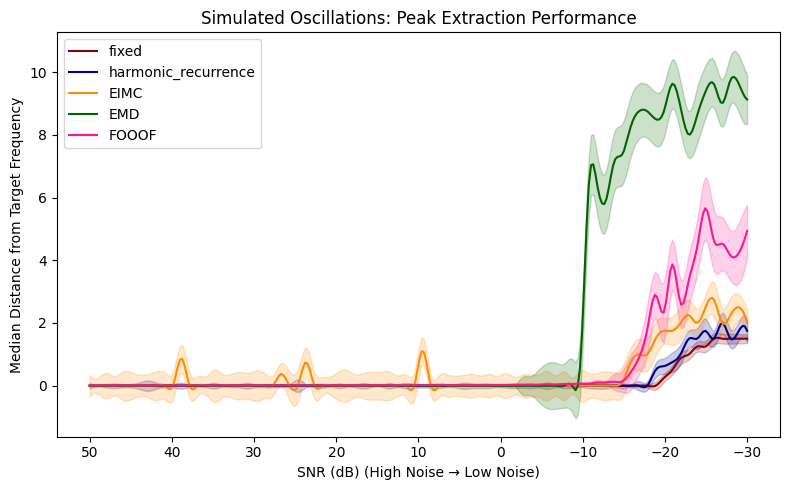

Processing method: fixed
Processing method: harmonic_recurrence
Processing method: EIMC
Processing method: EMD
Processing method: FOOOF


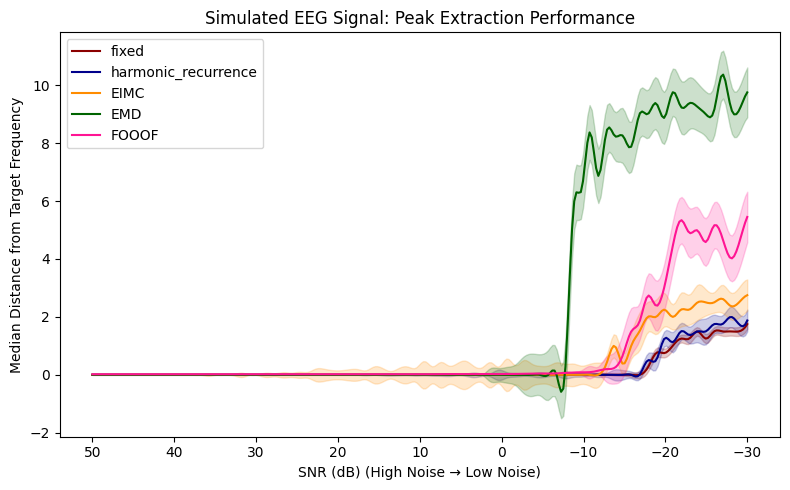

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Setting up parameters
sf = 1000  # Sampling frequency
length = 4  # Signal duration in seconds
n_times = 100  # Number of bootstrap iterations
freqs = [2, 6, 12, 24]  # Target frequencies
amps = [1, 1, 1, 1]  # Amplitudes of target frequencies
FREQ_BANDS = [[1, 5], [5, 10], [10, 20], [20, 30]]  # Frequency bands
snr_db_list = np.linspace(-30, 50, 80)  # SNR levels in decibels, from low to high

# Simulate the combined signal
def sim_combined(length, sf, components, component_variances):
    t = np.arange(0, length, 1 / sf)
    signal = np.zeros_like(t)
    for comp, var in zip(components.values(), component_variances):
        if isinstance(comp, dict):  # Power-law component
            power_law_noise = np.random.normal(0, np.sqrt(var), len(t))
            signal += power_law_noise
        elif isinstance(comp, list):  # Oscillatory components
            for osc in comp:
                signal += var * np.sin(2 * np.pi * osc['freq'] * t)
    return signal

# Generate signals
components = {
    'sim_powerlaw': {'exponent': -1},
    'sim_oscillation': [{'freq': freq} for freq in freqs]
}
component_variances = [1 for _ in range(len(freqs) + 1)]  # Include power-law component
simulated_EEG = sim_combined(length, sf, components, component_variances)
simulated_oscillations = np.sum([amp * np.sin(2 * np.pi * freq * np.arange(0, length, 1 / sf)) 
                                  for freq, amp in zip(freqs, amps)], axis=0)
signals = {'Simulated Oscillations': simulated_oscillations, 'Simulated EEG Signal': simulated_EEG}

# Analyze signals across SNR levels
for title, signal in signals.items():
    peaks_methods = ['fixed', 'harmonic_recurrence', 'EIMC', 'EMD', 'FOOOF']
    colors = ['darkred', 'darkblue', 'darkorange', 'darkgreen', 'deeppink', 'deeppink']

    signal_power = np.mean(signal ** 2)  # Calculate signal power

    data = []
    for method, color in zip(peaks_methods, colors):
        print(f"Processing method: {method}")
        for snr_db in snr_db_list:
            t = 0
            median_distance = []
            while t < n_times:
                noise_power = signal_power / (10 ** (snr_db / 10))  # Calculate noise power for given SNR
                noise_signal = np.random.normal(0, np.sqrt(noise_power), len(signal))  # Generate noise
                noised_signal = signal + noise_signal

                # Parameters for Biotuner
                prominences = {'fixed': 10, 'harmonic_recurrence': 6, 'EMD': 1, 'FOOOF': 10, 'EIMC': 7}
                rel_heights = {'fixed': 1, 'harmonic_recurrence': 1, 'EMD': 0.7, 'FOOOF': 1, 'EIMC': 1}

                # Biotuner peak extraction
                biotuning = compute_biotuner(sf=sf, peaks_function=method, precision=0.5)
                biotuning.peaks_extraction(
                    noised_signal, min_freq=1, max_freq=50, min_harms=2, harm_limit=128, FREQ_BANDS=FREQ_BANDS,
                    verbose=False, graph=False, prominence=prominences[method], rel_height=rel_heights[method],
                    nIMFs=3, keep_first_IMF=True, n_peaks=4
                )

                if len(biotuning.peaks) == 0:
                    median_distance.append(np.nan)
                else:
                    list_distance = [
                        abs(p - min(freqs, key=lambda f: abs(f - p))) for p in biotuning.peaks
                    ]
                    median_distance.append(np.nanmedian(list_distance))
                t += 1

            data.append([method, snr_db, np.nanmedian(median_distance), np.nanstd(median_distance)])

    # Create DataFrame
    df = pd.DataFrame(data, columns=["Method", "SNR (dB)", "Median distance", "Std deviation"])

    # Plot results
    # Plot results
    # Plot results
    plt.figure(figsize=(8, 5))
    for method, color in zip(peaks_methods, colors):
        # Sort SNR in descending order to reverse the x-axis display
        df_method = df[df["Method"] == method].sort_values(by="SNR (dB)", ascending=False)
        x = df_method["SNR (dB)"]
        y = df_method["Median distance"]
        yerr = df_method["Std deviation"] / np.sqrt(n_times) * 1.96  # 95% CI

        # Reverse the order of x to ascending for interpolation
        x_interp = x[::-1]  # Reverse to make it increasing
        y_interp = y[::-1]  # Match order
        yerr_interp = yerr[::-1]  # Match order

        # Smooth line interpolation
        xnew = np.linspace(x_interp.min(), x_interp.max(), 300)
        spl = make_interp_spline(x_interp, y_interp, k=3)
        y_smooth = spl(xnew)
        spl_err = make_interp_spline(x_interp, yerr_interp, k=3)
        yerr_smooth = spl_err(xnew)

        plt.plot(xnew, y_smooth, label=method, color=color)
        plt.fill_between(xnew, y_smooth - yerr_smooth, y_smooth + yerr_smooth, color=color, alpha=0.2)

    # Adjust plot to reflect descending SNR
    plt.title(f"{title}: Peak Extraction Performance")
    plt.xlabel("SNR (dB) (High Noise → Low Noise)")
    plt.ylabel("Median Distance from Target Frequency")
    plt.legend()
    plt.tight_layout()
    plt.gca().invert_xaxis()  # Reverse the x-axis to show low SNR (high noise) on the right
    plt.show()





### Metrics on ECG

In [100]:
import neurokit2 as nk
from biotuner.biotuner_object import compute_biotuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
sampling_rate = 1000
duration = 90
heart_rate = 120
noise = 0.1
n_bootstraps = 5
precision = 0.01

# Standard deviations for heart rate
std_values = [1, 10, 20, 30]
noises = [0.01, 0.1, 0.5]

# Function to simulate ECG and compute harmonicity metrics
def simulate_and_compute_metrics(std, sampling_rate, duration, heart_rate, noise):
    ecg = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=heart_rate, heart_rate_std=std, noise=noise)
    print('ECG SIMULATED')
    # Initialize BioTuning object
    biotuning = compute_biotuner(sf=sampling_rate, peaks_function='EMD', precision=precision)
    # Perform peak extraction
    biotuning.peaks_extraction(ecg, min_freq=0.001, max_freq=20, min_harms=2, harm_limit=128, 
                               verbose=False, graph=False, nIMFs=6, keep_first_IMF=False, n_peaks=6)
    # Select the first 4 peaks
    biotuning.peaks = biotuning.peaks[0:4]
    
    # Compute harmonicity metrics
    peaks = list(biotuning.peaks)
    print(peaks)
    peaks_ratios = compute_peak_ratios(peaks, rebound=True, octave=2, sub=False)

    _, _, _, cons = consonance_peaks(peaks, 0.1)
    tenney = tenneyHeight(peaks)
    harm_sim_temp = ratios2harmsim(peaks_ratios)
    print('harmsim_temp', harm_sim_temp)
    harmsim = np.nanmean(harm_sim_temp)
    print('harmsim', harmsim)
    _, _, subharm, _ = compute_subharmonic_tension(peaks, 10, 200, min_notes=2)
    subharm_tension = subharm[0]
    peaks_euler = [int(round(num, 2) * 100) for num in peaks]
    euler_ = euler(*peaks_euler)
    print(subharm_tension)
    return {
        'consonance': cons,
        'tenney': tenney,
        'harmonic_similarity': harmsim,
        'subharmonic_tension': subharm_tension,
        'euler': euler_
    }

# Bootstrapping and collecting results
results = {std: {'consonance': [], 'tenney': [], 'harmonic_similarity': [], 'subharmonic_tension': [], 'euler': []} for std in std_values}


for std in std_values:
    summed_metrics = {
    'consonance': 0.0,
    'tenney': 0.0,
    'harmonic_similarity': 0.0,  # Assuming harmonic_similarity arrays have length 3
    'subharmonic_tension': 0.0,
    'euler': 0.0
    }
    metrics_all = []
    for i in range(n_bootstraps):
        print(f'Standard deviation: {std}, Bootstrap iteration: {i}')
        metrics = simulate_and_compute_metrics(std, sampling_rate, duration, heart_rate, noise)
        metrics_all.append(metrics)
    # Sum up each metric across all iterations
    for metrics in metrics_all:
        
        summed_metrics['consonance'] += metrics['consonance']
        summed_metrics['tenney'] += metrics['tenney']
        if metrics['harmonic_similarity'] is float:
            summed_metrics['harmonic_similarity'] += metrics['harmonic_similarity']
        # check if not float
        if metrics['subharmonic_tension'] is float:
            summed_metrics['subharmonic_tension'] += metrics['subharmonic_tension']
        summed_metrics['euler'] += metrics['euler']
        
    # Compute the average for each metric
    averaged_metrics = {key: value / n_bootstraps for key, value in summed_metrics.items()} 
    results[std]['consonance'] = [averaged_metrics['consonance']]
    results[std]['tenney'] = [averaged_metrics['tenney']]
    results[std]['harmonic_similarity'] = [averaged_metrics['harmonic_similarity']]
    results[std]['subharmonic_tension'] = [averaged_metrics['subharmonic_tension']]
    results[std]['euler'] = [averaged_metrics['euler']]
    



Standard deviation: 1, Bootstrap iteration: 0
ECG SIMULATED


c:\Users\User\anaconda3\envs\goofi\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 100000 is greater than input length  = 90000, using nperseg = 90000
  warnings.warn('nperseg = {0:d} is greater than input length '


[0.06, 0.14, 0.25, 0.7]
harmsim_temp [40.         40.         31.42857143 31.42857143 35.71428571 10.85714286]
harmsim 31.571428571428573


c:\users\user\github\biotuner\biotuner\metrics.py:913: RuntimeWarning: divide by zero encountered in double_scalars
  harm_temp.append(1 / delta_norm)


1.6977234433094716e-16
Standard deviation: 1, Bootstrap iteration: 1
ECG SIMULATED
[0.05, 0.17, 0.25, 0.93]
harmsim_temp [ 2.31182796 40.          2.53004428  9.64705882 15.29411765  3.05376344]
harmsim 12.139468690702087
0.0
Standard deviation: 1, Bootstrap iteration: 2
ECG SIMULATED
[0.09, 0.25, 0.25, 0.74]
harmsim_temp [40.          6.59459459  7.56756757]
harmsim 18.054054054054053
0.005033557046979906
Standard deviation: 1, Bootstrap iteration: 3
ECG SIMULATED
[0.08, 0.16, 0.25, 0.9]
harmsim_temp [22.22222222 40.          5.27777778 10.         30.         28.88888889]
harmsim 22.73148148148148
0.0
Standard deviation: 1, Bootstrap iteration: 4
ECG SIMULATED
[0.06, 0.12, 0.25, 0.75]
harmsim_temp [ 8.         33.33333333 40.         66.66666667 10.         18.33333333]
harmsim 29.38888888888889
0.0
Standard deviation: 10, Bootstrap iteration: 0
ECG SIMULATED
[0.07, 0.25, 0.2, 0.86]
harmsim_temp [ 4.76744186 40.          6.23255814]
harmsim 17.0
0.005763688760806927
Standard deviatio

### Harmonicity on Simulated EEG

In [250]:
import neurokit2 as nk
from biotuner.biotuner_object import compute_biotuner
from neurodsp.sim import sim_combined
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sampling_rate = 1000
duration = 5
slopes = [-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, -0.1]  # Varying levels of slope in the power law
n_bootstraps = 150
precision = 0.1

# Frequencies and amplitude
freqs = [2.4, 5.8, 13, 23.1]
#freqs = [2, 6, 12, 24]
FREQ_BANDS = [[1, 5], [5, 10], [10, 20], [20, 30]]

# Function to simulate EEG and compute harmonicity metrics
def simulate_and_compute_metrics(slope, sampling_rate, duration):
    components = {
        'sim_powerlaw': {'exponent': slope},
        'sim_oscillation': [{'freq': freq} for freq in freqs]
    }
    component_variances = [1 for _ in range(len(freqs) + 1)]
    
    # Simulate the EEG signal
    simulated_EEG = sim_combined(duration, sampling_rate, components=components, component_variances=component_variances)
    
    # Initialize BioTuning object
    biotuning = compute_biotuner(sf=sampling_rate, peaks_function='EMD', precision=precision)
    
    # Perform peak extraction
    biotuning.peaks_extraction(simulated_EEG, min_freq=1, max_freq=100, min_harms=2, harm_limit=128, 
                               verbose=False, graph=False, nIMFs=6, keep_first_IMF=False, n_peaks=6)
    
    # Select the first 4 peaks
    biotuning.peaks = biotuning.peaks[0:3]
    
    # Compute harmonicity metrics
    peaks = list(biotuning.peaks)
    peaks_ratios = compute_peak_ratios(peaks, rebound=True, octave=2, sub=False)
    

    # Compute metrics for the selected peaks
    _, _, _, cons = consonance_peaks(peaks, 0.001)
    if np.isnan(cons):
        print(peaks)
        print('Only octaves')
        cons = 2.0
    tenney = tenneyHeight(peaks)
    harmsim = np.nanmean(ratios2harmsim(peaks_ratios))
    _, _, subharm, _ = compute_subharmonic_tension(peaks, 5, 150, min_notes=2)
    subharm_tension = subharm[0] if isinstance(subharm[0], (int, float)) else 0.0  # Ensure numeric type
    peaks_euler = [int(round(num, 2) * 1000) for num in peaks]
    euler_ = euler(*peaks_euler)
    
    
    return {
        'consonance': cons,
        'tenney': tenney,
        'harmonic_similarity': harmsim,
        'subharmonic_tension': subharm_tension,
        'euler': euler_
    }

# Bootstrapping and collecting results
results = {slope: {'consonance': [], 'tenney': [], 'harmonic_similarity': [], 'subharmonic_tension': [], 'euler': []} for slope in slopes}

for slope in slopes:
    metrics_all = []
    for i in range(n_bootstraps):
        print(f'Slope: {slope}, Bootstrap iteration: {i}')
        metrics = simulate_and_compute_metrics(slope, sampling_rate, duration)
        metrics_all.append(metrics)

    # Summing metrics across all iterations
    summed_metrics = {
        'consonance': sum([metrics['consonance'] for metrics in metrics_all]),
        'tenney': sum([metrics['tenney'] for metrics in metrics_all]),
        'harmonic_similarity': sum([metrics['harmonic_similarity'] for metrics in metrics_all]),
        'subharmonic_tension': sum([metrics['subharmonic_tension'] for metrics in metrics_all]),
        'euler': sum([metrics['euler'] for metrics in metrics_all])
    }
    
    std_devs = {
        'consonance': np.std([metrics['consonance'] for metrics in metrics_all]),
        'tenney': np.std([metrics['tenney'] for metrics in metrics_all]),
        'harmonic_similarity': np.std([metrics['harmonic_similarity'] for metrics in metrics_all]),
        'subharmonic_tension': np.std([metrics['subharmonic_tension'] for metrics in metrics_all]),
        'euler': np.std([metrics['euler'] for metrics in metrics_all])
    }

    # Compute the average for each metric
    averaged_metrics = {key: value / n_bootstraps for key, value in summed_metrics.items()}
    std_devs = {key: value for key, value in std_devs.items()}
    # Store averaged metrics in the results dictionary
    results[slope]['consonance'] = [averaged_metrics['consonance']]
    results[slope]['tenney'] = [averaged_metrics['tenney']]
    results[slope]['harmonic_similarity'] = [averaged_metrics['harmonic_similarity']]
    results[slope]['subharmonic_tension'] = [averaged_metrics['subharmonic_tension']]
    results[slope]['euler'] = [averaged_metrics['euler']]




Slope: -2, Bootstrap iteration: 0
Slope: -2, Bootstrap iteration: 1
Slope: -2, Bootstrap iteration: 2
Slope: -2, Bootstrap iteration: 3
Slope: -2, Bootstrap iteration: 4
Slope: -2, Bootstrap iteration: 5
Slope: -2, Bootstrap iteration: 6
Slope: -2, Bootstrap iteration: 7
Slope: -2, Bootstrap iteration: 8
Slope: -2, Bootstrap iteration: 9
Slope: -2, Bootstrap iteration: 10
Slope: -2, Bootstrap iteration: 11
Slope: -2, Bootstrap iteration: 12
Slope: -2, Bootstrap iteration: 13
Slope: -2, Bootstrap iteration: 14
Slope: -2, Bootstrap iteration: 15
Slope: -2, Bootstrap iteration: 16
Slope: -2, Bootstrap iteration: 17
Slope: -2, Bootstrap iteration: 18
Slope: -2, Bootstrap iteration: 19
Slope: -2, Bootstrap iteration: 20
Slope: -2, Bootstrap iteration: 21
Slope: -2, Bootstrap iteration: 22
Slope: -2, Bootstrap iteration: 23
Slope: -2, Bootstrap iteration: 24
Slope: -2, Bootstrap iteration: 25
Slope: -2, Bootstrap iteration: 26
Slope: -2, Bootstrap iteration: 27
Slope: -2, Bootstrap iteration

In [251]:
results_low_harm = results
std_devs_low_harm = std_devs

In [247]:
results_high_harm = results
std_devs_high_harm = std_devs

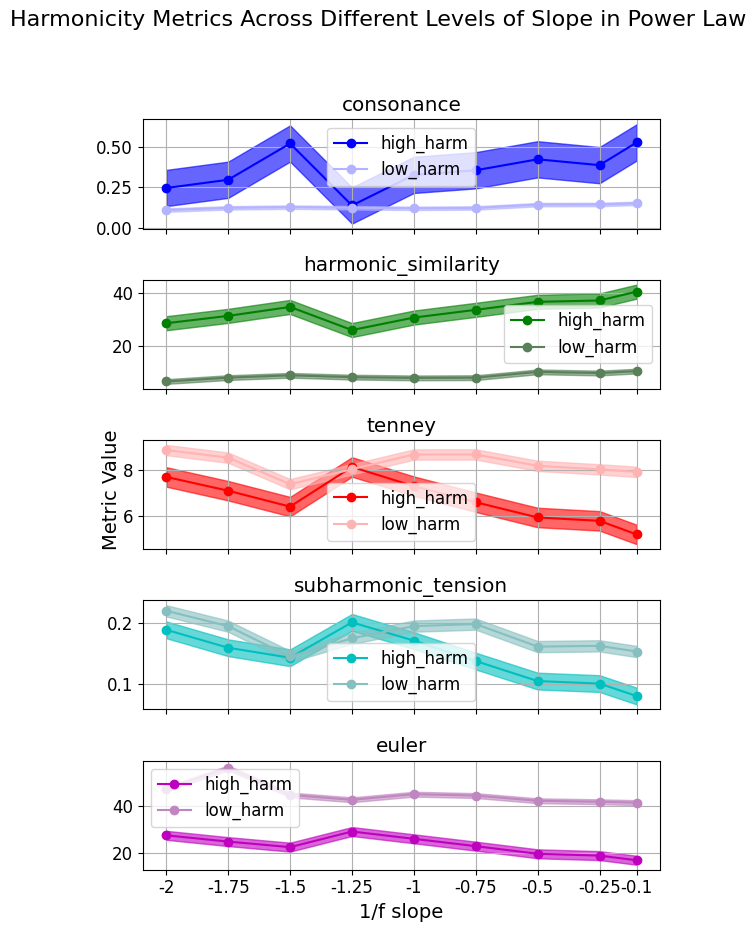

In [254]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import colorsys

# Function to adjust the hue of a color
def adjust_hue(color, amount=0.1):
    rgb = mcolors.to_rgb(color)
    hsv = colorsys.rgb_to_hsv(*rgb)
    new_sat = (hsv[1] - amount)
    new_rgb = colorsys.hsv_to_rgb(hsv[0], new_sat, hsv[2])
    return new_rgb

# Assuming results_low_harm, std_devs_low_harm, results_high_harm, std_devs_high_harm, slopes, and n_bootstraps are predefined
fig, axs = plt.subplots(len(metrics_labels), 1, figsize=(6, 2 * len(metrics_labels)), sharex=True)

base_colors = ['b', 'g', 'r', 'c', 'm']  # Original colors for each metric
labels = ['high_harm', 'low_harm']
metrics_labels = ['consonance', 'harmonic_similarity', 'tenney', 'subharmonic_tension', 'euler']

for i, metric in enumerate(metrics_labels):
    for j, (results, std_devs) in enumerate(zip([results_high_harm, results_low_harm], [std_devs_high_harm, std_devs_low_harm])):
        # Extract and rescale the metric values between 0 and 1
        metric_values = [results[slope][metric][0] for slope in slopes]
        
        # Calculate the CI
        CI = 1.96 * np.array(std_devs[metric]) / np.sqrt(n_bootstraps)
        
        # Adjust color hue: slightly different hue for high_harm and low_harm
        color = base_colors[i]
        adjusted_color = adjust_hue(color, amount=0.7 * j)  # Adjust hue for the second line
        
        # Plotting the metric values with CI on the corresponding subplot
        axs[i].plot(slopes, metric_values, marker='o', color=adjusted_color, label=labels[j])
        axs[i].fill_between(slopes, np.array(metric_values) - CI, np.array(metric_values) + CI, color=adjusted_color, alpha=0.6)

    axs[i].set_title(metric)
    axs[i].grid(True)
    axs[i].legend()

# Customizing the shared x-axis and overall layout
fig.suptitle('Harmonicity Metrics Across Different Levels of Slope in Power Law', fontsize=16)
plt.xlabel('1/f slope', fontsize=14)
fig.text(0.04, 0.5, 'Metric Value', va='center', rotation='vertical', fontsize=14)
plt.xticks(slopes, [s for s in slopes], fontsize=12)

# Add a shared legend outside of the plot
#fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()


### Figure 9a. Transitional Harmony in I-IV-V-I progression

c:\users\user\github\biotuner\biotuner\metrics.py:845: RuntimeWarning: divide by zero encountered in double_scalars
  harm_temp.append(1/delta_norm)


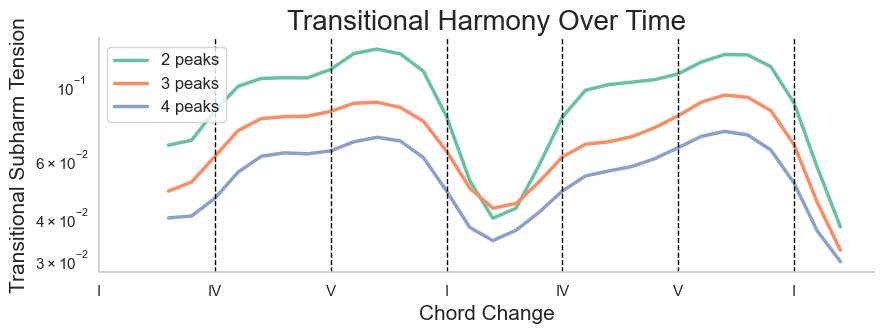

In [15]:
from biotuner.transitional_harmony import transitional_harmony
from biotuner.dictionaries import chord_frequencies
progressions = {
    'I-IV-V Progression': ['C', 'F', 'G', 'C', 'F', 'G', 'C']
}
precision=1
# Helper function to generate the signal for each chord progression
def generate_signal_for_progression(chord_sequence, chord_freqs, duration_per_chord=1, sampling_rate=10000):
    signal_length = duration_per_chord * len(chord_sequence) * sampling_rate
    time = np.linspace(0, duration_per_chord * len(chord_sequence), signal_length)
    signal = np.zeros_like(time)

    for i, chord in enumerate(chord_sequence):
        start = i * duration_per_chord * sampling_rate
        end = (i + 1) * duration_per_chord * sampling_rate
        for freq in chord_freqs[chord]:
            signal[start:end] += np.sin(2 * np.pi * freq * time[start:end])

    return signal, time

overlap=80
tharm=15
# Generate signals for each progression
sig_, time_ = generate_signal_for_progression(progressions['I-IV-V Progression'], chord_frequencies)

th = transitional_harmony(sf=10000, data=sig_, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=tharm, max_freq=1000, max_harm_freq=20000,
                        FREQ_BANDS=None, n_peaks=2)
th_1, time_vec_final, subharm_melody = th.compute_trans_harmony(overlap=overlap, mode='win_overlap', delta_lim=5)

th2 = transitional_harmony(sf=10000, data=sig_, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=tharm, max_freq=1000, max_harm_freq=20000,
                        FREQ_BANDS=None, n_peaks=3)
th2_1, time_vec_final, subharm_melody = th2.compute_trans_harmony(overlap=overlap, mode='win_overlap', delta_lim=5)

th3 = transitional_harmony(sf=10000, data=sig_, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=tharm, max_freq=1000, max_harm_freq=20000,
                        FREQ_BANDS=None, n_peaks=4)

th3_1, time_vec_final, subharm_melody = th3.compute_trans_harmony(overlap=overlap, mode='win_overlap', delta_lim=5)

from scipy.ndimage import gaussian_filter1d

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(9, 3.5))

# Generate two separate color palettes for H10 and H5
colors_h10 = sns.color_palette("Set2", n_colors=3)  # Degradé for H10
colors_h5 = sns.color_palette("Oranges_r", n_colors=5)  # Degradé for H5

# Plot the transitional harmony vectors for H15
for i, trans_subharm in enumerate([th_1, th2_1, th3_1]):
    sigma = 1.  # Smoothing parameter
    y_smooth = gaussian_filter1d(trans_subharm, sigma=sigma)
    plt.plot(time_vec_final, y_smooth, linewidth=2.5, color=colors_h10[i], label=f'{i+2} peaks')


# Customization of the plot
plt.xlabel('Chord Change', fontsize=15)
plt.ylabel('Transitional Subharm Tension', fontsize=15)
plt.title('Transitional Harmony Over Time', fontsize=20)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['I', 'IV', 'V', 'I', 'IV', 'V', 'I'])

plt.legend(loc='upper left', fontsize=12)

# add vertical dashed black lines for chord changes
for i in range(1, 7):
    chord_change_time = i * 1
    plt.axvline(x=chord_change_time, color='black', linestyle='--', linewidth=1)
# log y-scale
plt.yscale('log')
sns.despine()  # Remove top and right borders
sns.set(font_scale=1)  # Set font scale
plt.grid(False)  # Remove grid
plt.tight_layout()  # Ensure everything fits without overlapping

# Save and show the figure
#plt.savefig('transitional_harmony_I_IV_V_I.png', dpi=300)
plt.show()

### Figure 9b. Smoothed transitional harmony for ecg simulated signals

C:\Users\User\AppData\Local\Temp\ipykernel_10072\926778720.py:39: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Dark2_r')


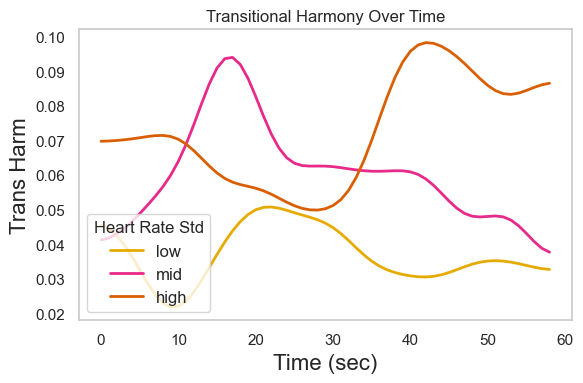

In [16]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from biotuner.transitional_harmony import transitional_harmony

# Parameters
sampling_rate = 1000
duration = 60
heart_rate = 120
noise = 0.1
std_values = [1, 15, 30]  # Heart rate standard deviations
precision = 1

# Function to simulate ECG and apply transitional harmony
def simulate_and_compute_th(std):
    ecg = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=heart_rate, heart_rate_std=std, noise=noise)
    th = transitional_harmony(sf=sampling_rate, data=ecg, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=5, 
                              min_freq=0.1, max_freq=50, max_harm_freq=2000, FREQ_BANDS=None, n_peaks=2)
    trans_subharm, _, _ = th.compute_trans_harmony(overlap=0.7, mode='win_overlap', delta_lim=100, keep_first_IMF=False)
    return trans_subharm, ecg

# Simulate ECG data and compute transitional harmony for each standard deviation
transitional_harmonies = []
ecgs = []
for std in std_values:
    ts, ecg = simulate_and_compute_th(std)
    transitional_harmonies.append(ts)
    ecgs.append(ecg)
    

# Plotting
plt.figure(figsize=(6, 4))
sns.set(style="whitegrid")
# Updated lines to select colors 2, 4, and 6 from Set2_r colormap
total_colors_in_set2_r = 8
color_indices = np.array([2, 4, 6]) / total_colors_in_set2_r
cmap = plt.cm.get_cmap('Dark2_r')
labels = ['low', 'mid', 'high']
# Use the updated color_indices in the plotting loop
for th, label, color in zip(transitional_harmonies, labels, cmap(color_indices)):
    th_filtered = gaussian_filter1d(th, sigma=4)
    plt.plot(th_filtered, label=label, linewidth=2, color=color)

# Customize plot
plt.legend(loc='lower left', fontsize=12, title='Heart Rate Std', title_fontsize=12)
plt.title("Transitional Harmony Over Time")
plt.xlabel("Time (sec)", fontsize=16)
plt.ylabel("Trans Harm", fontsize=16)
plt.grid(False)
plt.tight_layout()
#plt.savefig('trans_harm_heartrate_IF.png', dpi=300)
plt.show()

### Figure 9c. Distribution of transitional harmony values

Heart rate std: 1, Number of trans_subharm values stored: 2
First trans_subharm value for std 1: [0.05848468419625915, 0.05021008403361345, 0.0, 0.0, 0.0, 0.05021008403361345, 0.05021008403361345, 0.05021008403361345, 0.05021008403361345, 0.0, 0.0, 0.0, 0.1004201680672269, 0.0, 0.13103520978283786, 0.0, 0.06694677871148459, 0.0, 0.05021008403361345, 0.06694677871148459, 0.06694677871148459, 0.1004201680672269, 0.029242342098129575, 0.029242342098129575, 0.029242342098129575, 0.029242342098129575, 0.0, 0.05021008403361345, 0.05021008403361345, 0.05021008403361345, 0.05021008403361345, 0.0, 0.05021008403361345, 0.05021008403361345, 0.0, 0.027777777777777776, 0.04784688995215311, 0.05848468419625915, 0.06694677871148459, 0.037037037037037035, 0.09013417884385626, 0.08094356485198391, 0.029242342098129575, 0.06694677871148459, 0.0, 0.09865506011016847, 0.09865506011016847, 0.0, 0.05021008403361345, 0.05021008403361345, 0.0, 0.0, 0.05021008403361345, 0.06692792010811355, 0.07739279398762158

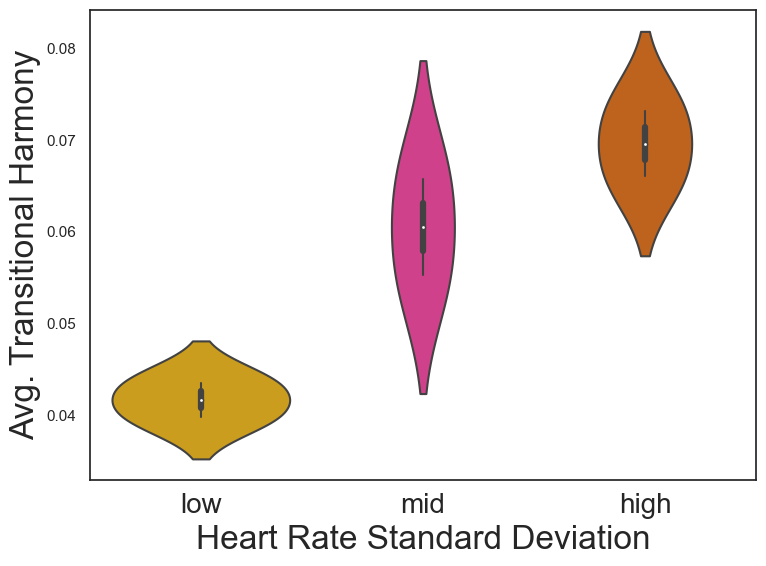

In [17]:
import neurokit2 as nk
from biotuner.transitional_harmony import transitional_harmony
import numpy as np

# Parameters
sampling_rate = 1000
duration = 60
heart_rate = 120
noise = 0.1
n_bootstraps = 2

# Standard deviations for heart rate
std_values = [1, 15, 30]

# Function to simulate ECG and compute transitional harmony
def simulate_and_compute_th(std, sampling_rate, duration, heart_rate, noise):
    ecg = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=heart_rate, heart_rate_std=std, noise=noise)
    th = transitional_harmony(sf=sampling_rate, data=ecg, peaks_function='EMD', n_harm=10, precision=1, n_trans_harm=5, min_freq=0.1, max_freq=50, max_harm_freq=2000,
                              FREQ_BANDS=None, n_peaks=2)
    trans_subharm, _, _ = th.compute_trans_harmony(overlap=0.7, mode='win_overlap', delta_lim=100, keep_first_IMF=False)
    return trans_subharm

# Bootstrapping
results = {std: [] for std in std_values}

for std in std_values:
    for _ in range(n_bootstraps):
        trans_subharm = simulate_and_compute_th(std, sampling_rate, duration, heart_rate, noise)
        results[std].append(trans_subharm)

# Displaying a summary of the results
for std, values in results.items():
    print(f"Heart rate std: {std}, Number of trans_subharm values stored: {len(values)}")
    # Example: Accessing the first trans_subharm value for each std
    print(f"First trans_subharm value for std {std}: {values[0]}")

# Prepare data for DataFrame
averaged_data = []
for std, list_of_values in results.items():
    for values in list_of_values:
        avg_value = np.mean(values)  # Calculate average of each list
        averaged_data.append({'Heart Rate Std': std, 'Average Transitional Harmony': avg_value})

# Create DataFrame
df_avg = pd.DataFrame(averaged_data)

# Create the violin plot with averaged values
plt.figure(figsize=(8, 6))
# set white background
sns.set_style("white")
sns.violinplot(x='Heart Rate Std', y='Average Transitional Harmony', data=df_avg, palette='Dark2_r')

# Customizing plot
plt.title('')
plt.xlabel('Heart Rate Standard Deviation', fontsize=24)
plt.ylabel('Avg. Transitional Harmony', fontsize=24)
# set x-ticks to 'low', 'mid', 'high'
plt.xticks(range(len(std_values)), ['low', 'mid', 'high'], fontsize=20)
# change font size
sns.set(font_scale=1.5)

plt.tight_layout()
#plt.savefig('violin_plot_trans_harm_heartrate3.png', dpi=300)
# Show plot
plt.show()


# Transitional harmony on simulated EEG

In [3]:
import neurokit2 as nk
from biotuner.transitional_harmony import transitional_harmony
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neurodsp.sim import sim_combined

# Parameters
sampling_rate = 1000
duration = 60
n_bootstraps = 100  # Number of bootstraps
slope = -1  # Power law slope

# Peaks for EEG simulation
peaks_sets = {
    'Set 1': [2, 6, 12, 24],
    'Set 2': [2.4, 5.8, 13, 23.1]
}

# Function to simulate EEG and compute transitional harmony
def simulate_and_compute_th(peaks, sampling_rate, duration, slope):
    # Define components for sim_combined
    components = {
        'sim_powerlaw': {'exponent': slope},
        'sim_oscillation': [{'freq': freq} for freq in peaks]
    }
    
    # Simulate the EEG signal
    simulated_EEG = sim_combined(duration, sampling_rate, components=components)
    
    # Compute transitional harmony
    th = transitional_harmony(sf=sampling_rate, data=simulated_EEG, peaks_function='EMD', n_harm=10, precision=0.5, n_trans_harm=5, 
                              min_freq=1, max_freq=50, max_harm_freq=2000, FREQ_BANDS=None, n_peaks=3)
    trans_subharm, _, _ = th.compute_trans_harmony(overlap=0.7, mode='win_overlap', delta_lim=150, keep_first_IMF=False)
    
    return trans_subharm

# Bootstrapping
results = {label: [] for label in peaks_sets.keys()}

for label, peaks in peaks_sets.items():
    for _ in range(n_bootstraps):
        trans_subharm = simulate_and_compute_th(peaks, sampling_rate, duration, slope)
        results[label].append(np.mean(trans_subharm))  # Store the mean of the transitional harmony values

# Prepare data for DataFrame
averaged_data = []
for label, values in results.items():
    for avg_value in values:
        averaged_data.append({'Peaks Set': label, 'Average Transitional Harmony': avg_value})

# Create DataFrame
df_avg = pd.DataFrame(averaged_data)




c:\users\user\github\biotuner\biotuner\metrics.py:1014: RuntimeWarning: divide by zero encountered in double_scalars
  harm_temp.append(1/delta_norm)


-10.332861016774197 2.714994404272947e-20


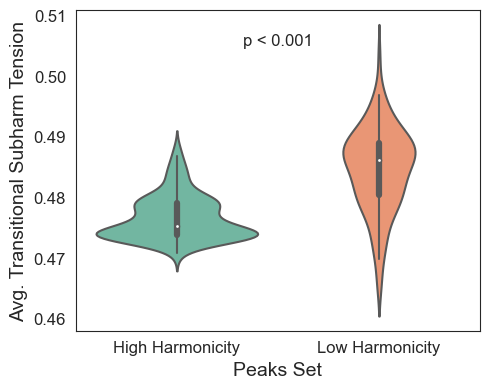

In [4]:
import scipy.stats as stats

# Replace 'Set 1' by High Harmonicity and 'Set 2' by Low Harmonicity
df_avg['Peaks Set'] = df_avg['Peaks Set'].replace({'Set 1': 'High Harmonicity', 'Set 2': 'Low Harmonicity'})

# Perform an independent t-test
high_harm = df_avg[df_avg['Peaks Set'] == 'High Harmonicity']['Average Transitional Harmony']
low_harm = df_avg[df_avg['Peaks Set'] == 'Low Harmonicity']['Average Transitional Harmony']
t_stat, p_value = stats.ttest_ind(high_harm, low_harm)
print(t_stat, p_value)


# Create the violin plot with averaged values
plt.figure(figsize=(5, 4))
sns.set_style("white")
sns.violinplot(x='Peaks Set', y='Average Transitional Harmony', data=df_avg, palette='Set2')

# Add the p-value to the plot
if p_value < 0.001:
    plt.text(0.5, max(df_avg['Average Transitional Harmony']) + 0.002, 'p < 0.001', ha='center', fontsize=12)
else:
    plt.text(0.5, max(df_avg['Average Transitional Harmony']) + 0.002, f'p = {p_value:.4f}', ha='center', fontsize=12)

# Customizing plot
plt.xlabel('Peaks Set', fontsize=14)
plt.ylabel('Avg. Transitional Subharm Tension', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


### Figure 10. Harmonic Connectivity

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.sim import sim_combined
from biotuner.harmonic_connectivity import harmonic_connectivity
import pandas as pd

# Parameters
sampling_rate = 1000
duration = 10  # in seconds
slope = -1
n_bootstraps = 100  # Number of bootstraps for variability estimation

# Frequencies for harmonic and non-harmonic sets
harm_freqs = [10, 20, 30]
nonharm_freqs = [9.6, 22.3, 29.5]

nonharm_freqs = [2.4, 5.8, 13, 23.1]
harm_freqs = [2, 6, 12, 24]

# Function to generate EEG signals
def generate_eeg_signal(freqs, duration, sampling_rate, slope):
    components = {
        'sim_powerlaw': {'exponent': slope},
        'sim_oscillation': [{'freq': freq} for freq in freqs]
    }
    component_variances = [1 for _ in range(len(freqs) + 1)]
    simulated_EEG = sim_combined(duration, sampling_rate, components=components, component_variances=component_variances)
    return simulated_EEG

# Frequency bands (example)
FREQ_BANDS = [[15, 26], [26, 36], [36, 46]]

# List to store bootstrapped results
bootstrapped_results = []

# Bootstrapping loop
for _ in range(n_bootstraps):
    # Generate signals
    eeg_harm1 = generate_eeg_signal(harm_freqs, duration, sampling_rate, slope)
    eeg_harm2 = generate_eeg_signal(harm_freqs, duration, sampling_rate, slope)
    eeg_nonharm = generate_eeg_signal(nonharm_freqs, duration, sampling_rate, slope)
    
    # Create pairs of signals
    signals_harm_harm = np.array([eeg_harm1, eeg_harm2])
    signals_harm_nonharm = np.array([eeg_harm1, eeg_nonharm])

    # Compute connectivity for each metric
    metrics = ['harmsim', 'subharm_tension', 'wPLI_crossfreq', 'RRCi']
    for metric in metrics:
        hc_harm_harm = harmonic_connectivity(sf=sampling_rate, data=signals_harm_harm, min_freq=1, max_freq=50, precision=0.1, peaks_function='EMD', n_harm=10, n_peaks=4)
        result_harm_harm = hc_harm_harm.compute_harm_connectivity(metric=metric, FREQ_BANDS=FREQ_BANDS, graph=False)
        
        hc_harm_nonharm = harmonic_connectivity(sf=sampling_rate, data=signals_harm_nonharm, min_freq=1, max_freq=50, precision=0.1, peaks_function='EMD', n_harm=10, n_peaks=4)
        result_harm_nonharm = hc_harm_nonharm.compute_harm_connectivity(metric=metric, FREQ_BANDS=FREQ_BANDS, graph=False)
        
        # Store the average results for the off-diagonal elements of the matrix
        harm_harm_value = np.nanmean(result_harm_harm[np.triu_indices_from(result_harm_harm, k=1)])
        harm_nonharm_value = np.nanmean(result_harm_nonharm[np.triu_indices_from(result_harm_nonharm, k=1)])

        bootstrapped_results.append({'Metric': metric, 'Pair Type': 'Harm-Harm', 'Value': harm_harm_value})
        bootstrapped_results.append({'Metric': metric, 'Pair Type': 'Harm-Nonharm', 'Value': harm_nonharm_value})


# Convert bootstrapped results to DataFrame
df = pd.DataFrame(bootstrapped_results)




c:\users\user\github\biotuner\biotuner\metrics.py:1014: RuntimeWarning: divide by zero encountered in double_scalars
  harm_temp.append(1/delta_norm)


c:\Users\User\anaconda3\envs\goofi\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


C:\Users\User\AppData\Local\Temp\ipykernel_21864\3175379112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric['Pair Type'] = data_metric['Pair Type'].replace({'Harm-Harm': 'H-H', 'Harm-Nonharm': 'H-NH'})
C:\Users\User\AppData\Local\Temp\ipykernel_21864\3175379112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric['Pair Type'] = data_metric['Pair Type'].replace({'Harm-Harm': 'H-H', 'Harm-Nonharm': 'H-NH'})
C:\Users\User\AppData\Local\Temp\ipykernel_21864\3175379112.py:16: Setting

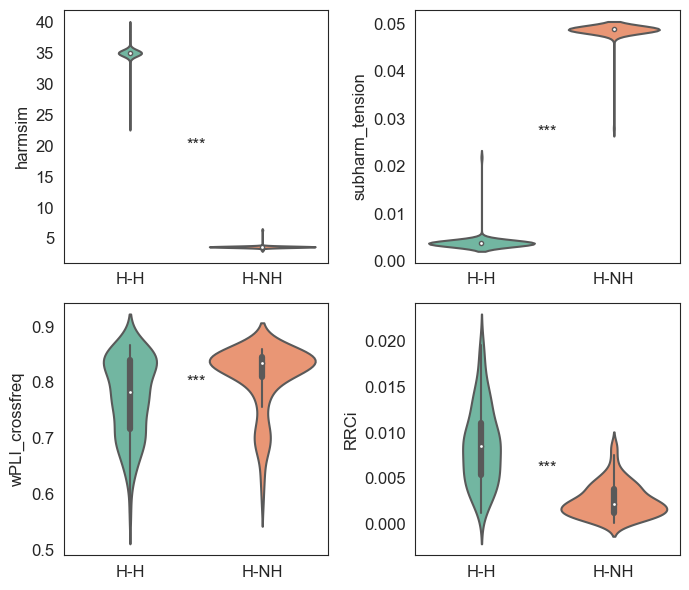

In [12]:
import scipy.stats as stats
plt.figure(figsize=(7, 6))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    
    # Subset data for the current metric
    data_metric = df[df['Metric'] == metric]
    
    # Perform t-test
    harm_harm_values = data_metric[data_metric['Pair Type'] == 'Harm-Harm']['Value']
    harm_nonharm_values = data_metric[data_metric['Pair Type'] == 'Harm-Nonharm']['Value']
    t_stat, p_value = stats.ttest_ind(harm_harm_values, harm_nonharm_values)
    
    # change Harm-Harm for H-H and Harm-Nonharm for H-NH
    data_metric['Pair Type'] = data_metric['Pair Type'].replace({'Harm-Harm': 'H-H', 'Harm-Nonharm': 'H-NH'})
    
    # Create violin plot
    sns.violinplot(x='Pair Type', y='Value', data=data_metric, palette='Set2')
    
    # Add p-value to the plot
    if p_value < 0.001:
        plt.text(0.5, np.mean(data_metric['Value']), '***', ha='center', fontsize=12)
    elif p_value < 0.01:
        plt.text(0.5, np.mean(data_metric['Value']), '**', ha='center', fontsize=12)
    elif p_value < 0.05:
        plt.text(0.5, np.mean(data_metric['Value']), '*', ha='center', fontsize=12)
    
    # Customize the plot
    plt.xlabel('')
    plt.ylabel(metric, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.tight_layout()
# save the plot in 300 dpi
plt.savefig('connectivity_metrics.png', dpi=300)
plt.show()

### Figure 11. Harmonic Spectrum

c:\Users\User\anaconda3\envs\goofi\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 10000 is greater than input length  = 2000, using nperseg = 2000
  warnings.warn('nperseg = {0:d} is greater than input length '


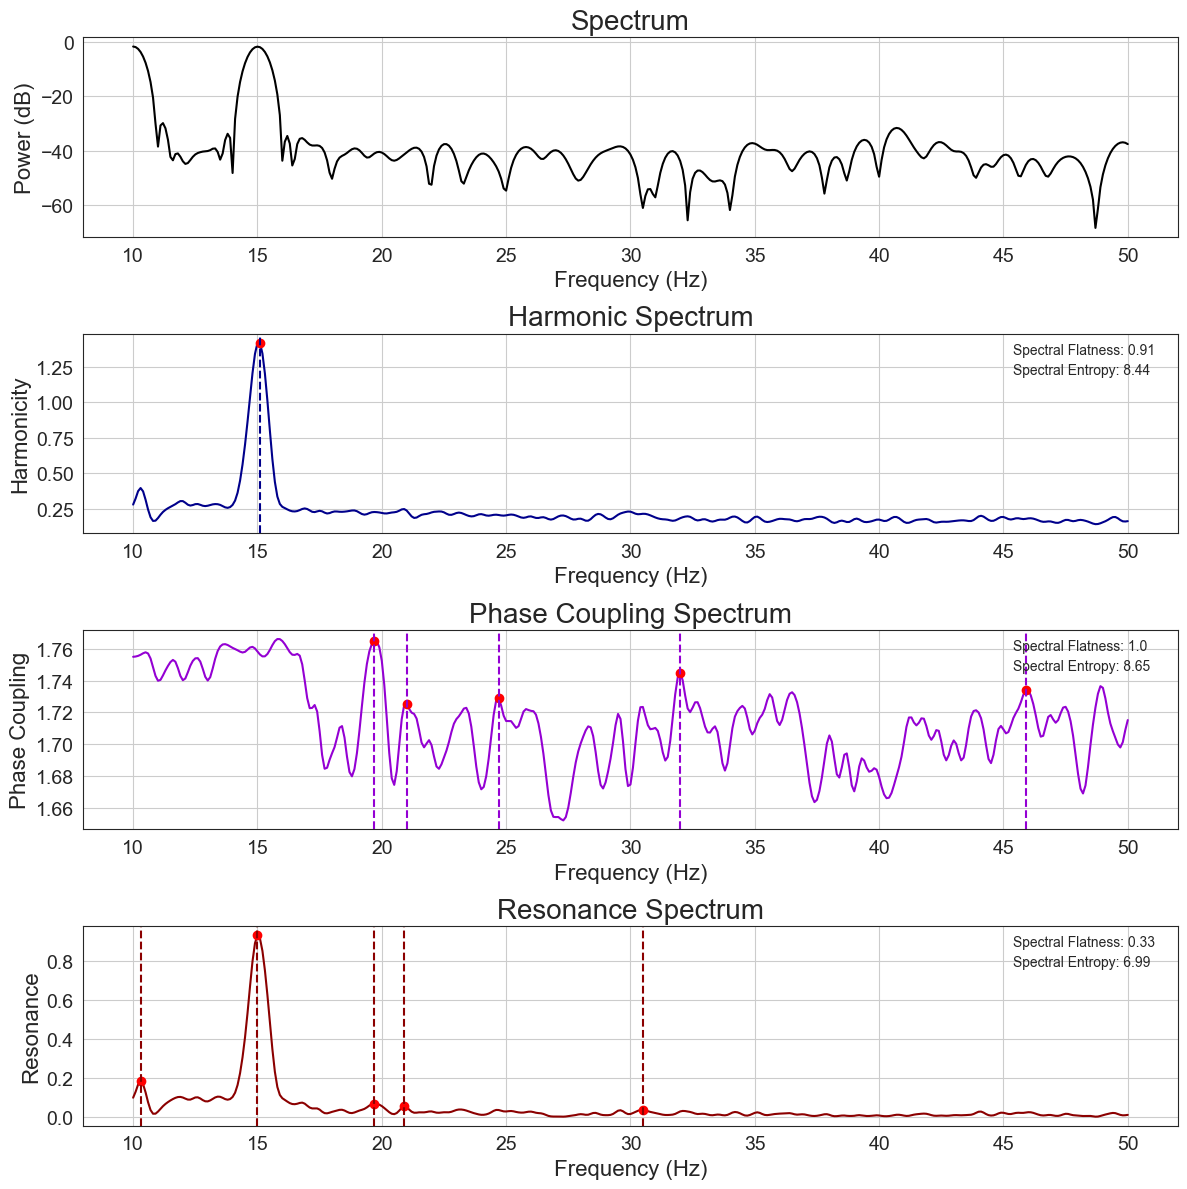

In [14]:
from biotuner.harmonic_spectrum import compute_global_harmonicity
import numpy as np
# clear plot
plt.clf()
# generate a signal with peaks at 10, 20 and 30 Hz
time = np.linspace(0, 1, 2000)
signal = np.sum([1 * np.sin(2 * np.pi * freq * time) for freq in [10, 20, 30]], axis=0)
# add 10% of noise
signal += np.random.normal(0, 0.2, len(time))

# generate a white noise signal
pink_noise = np.random.normal(0, 0.2, len(time))

harm_spectrum_df = compute_global_harmonicity(signal, 0.1, 10, 50, fs=1000,
                                             noverlap=1, power_law_remove=True, n_peaks=5, plot=True,
                                             smoothness=1, metric='harmsim', delta_lim=500, smoothness_harm=2, 
                                             n_harms=5, phase_mode=None)

In [1]:
import numpy as np
from biotuner.vizs import lissajous_curves

c:\Users\User\anaconda3\envs\goofi\lib\site-packages\IPython\core\completer.py:2963: ProvisionalCompleterWarning: ``Completion`` is a provisional API (as of IPython 6.0). It may change without warnings. Use in corresponding context manager.
  completion = Completion(
c:\Users\User\anaconda3\envs\goofi\lib\site-packages\IPython\core\completer.py:903: ProvisionalCompleterWarning: ``Completion`` is a provisional API (as of IPython 6.0). It may change without warnings. Use in corresponding context manager.
  yield Completion(new_start, new_end, new_text, type=c.type, _origin=c._origin, signature=c.signature)


[1, 28/25, 5/4, 133/100, 3/2, 167/100, 7/4, 47/25, 2]


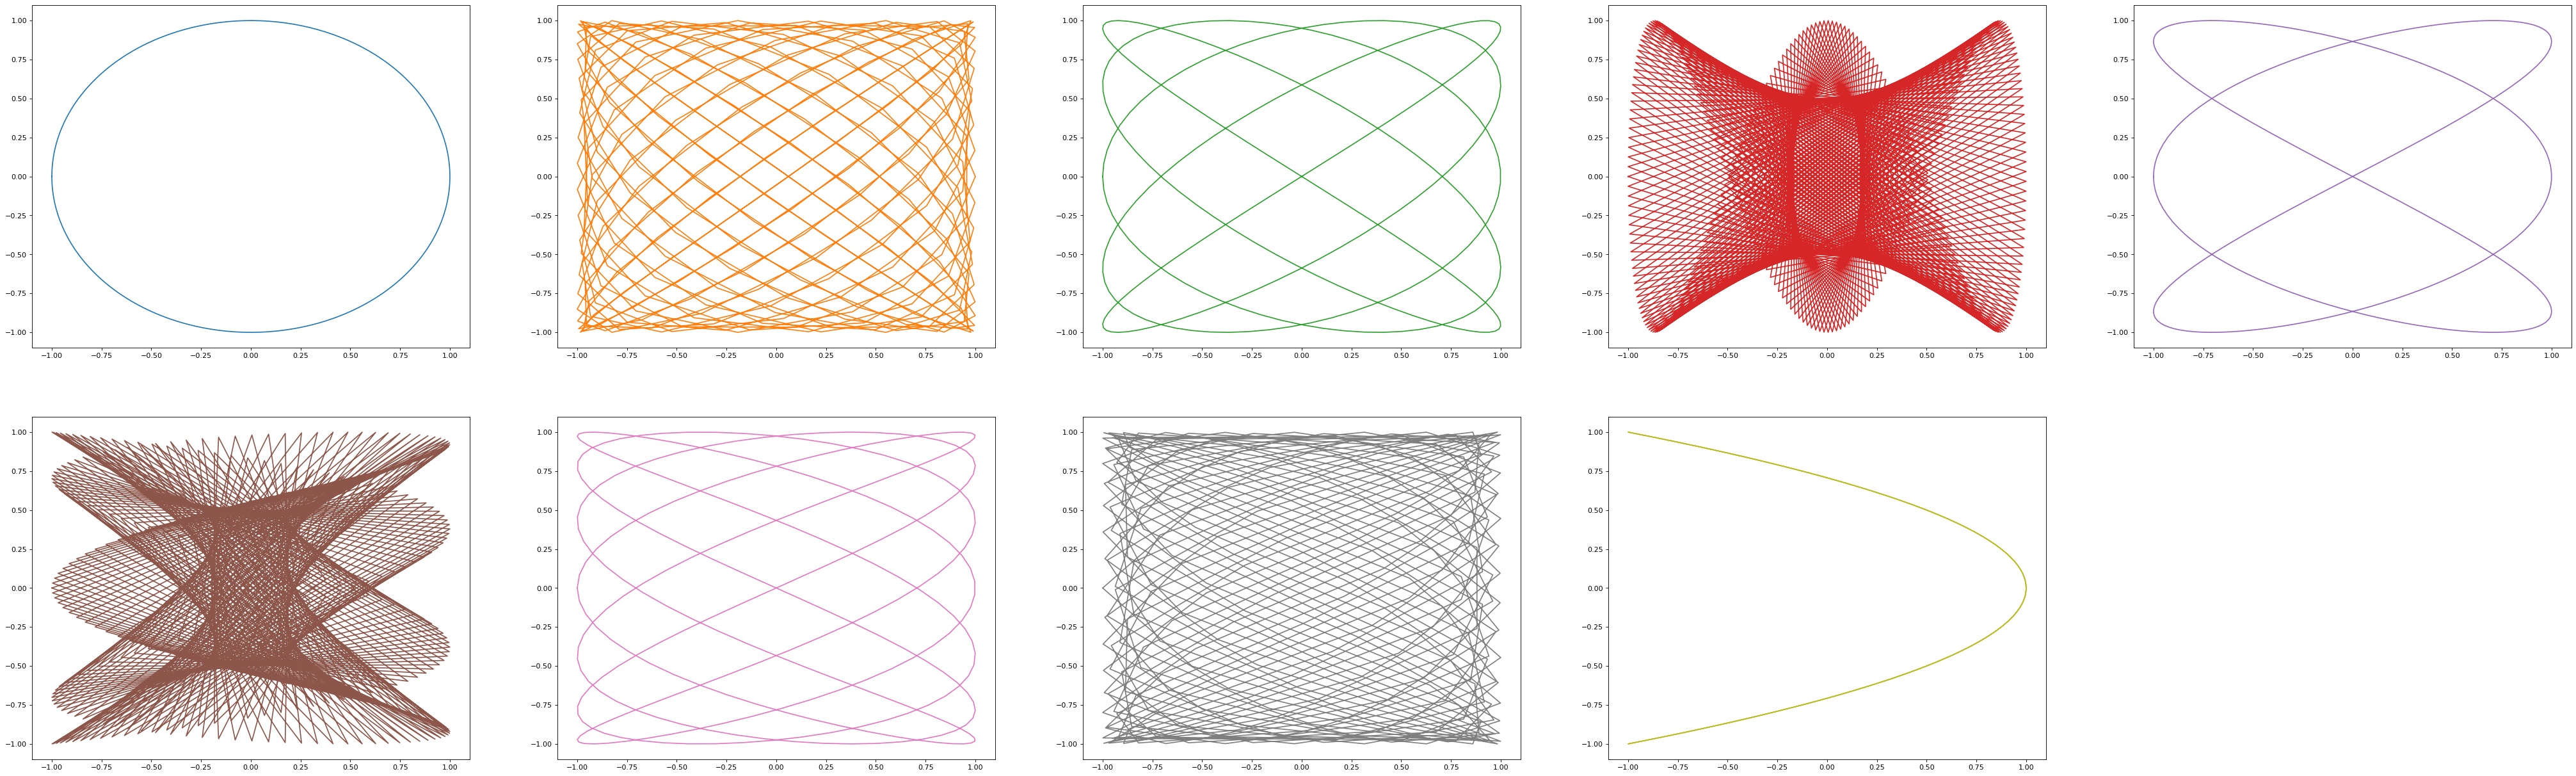

In [3]:
tuning = [1, 1.12, 1.25, 1.33, 1.5, 1.67, 1.75, 1.88, 2]
lissajous_curves(tuning)

In [34]:
## PLANT

import numpy as np
import matplotlib.pyplot as plt
import os
# import functions from the utils.py in the ../scripts folder
import sys
folderpath = '../../../../plant_sonification/plant_data/Hiver 2024/Fichier RAW/'
filename = 'Acer pensylvanicum 2024-02-28.raw'
# get all filenames in the folder that ends with .raw
filenames = [f for f in os.listdir(folderpath) if f.endswith('.raw')]
sf = 256

In [44]:
from scipy import signal

filename = filenames[2]
data = np.fromfile(folderpath + filename, dtype=np.float32)
data = data[~np.isnan(data)]

# take 2 hours of data
segment = data

segment = (segment - np.nanmin(segment)) / (np.nanmax(segment) - np.nanmin(segment))

# compute psd
f, Pxx = signal.welch(segment, sf, nperseg=5096, noverlap=5096//2, nfft=2**14)




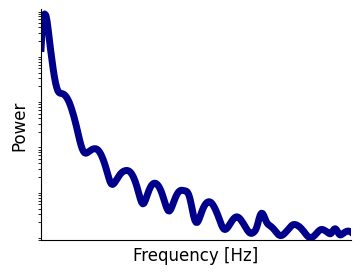

In [76]:
# Plot
plt.figure(figsize=(4, 3))
plt.semilogy(f, Pxx, color='darkblue', linewidth=5)

# Styling
plt.xlabel('Frequency [Hz]', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.xlim([0, 4])
plt.ylim([0.8e-8, 1e-3])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tick_params(top=False, right=False, left=False, bottom=False)

# Remove borders and background
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_facecolor('none')

# Save the plot as a transparent PNG at 300 dpi
plt.savefig('spectral_peaks.png', dpi=300, transparent=True)

# Display plot
plt.show()

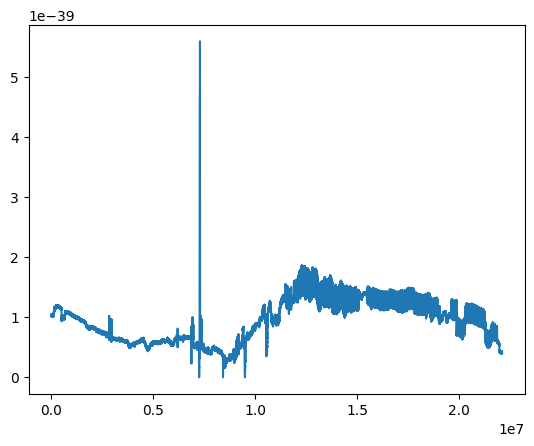

In [38]:
# plot data

plt.plot(data)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

# Generate a simple 1/f spectrum with peaks
freqs = np.linspace(0.1, 50, 500)
spectrum_1f = 1 / freqs
peaks = [10, 20, 30]  # Peak frequencies
peak_amplitudes = [3, 2, 1.5]  # Corresponding amplitudes
for peak, amp in zip(peaks, peak_amplitudes):
    spectrum_1f += amp * np.exp(-((freqs - peak) ** 2) / 2)

# Generate a heart rate spectrum using NeuroKit2
signal = nk.ecg_simulate(duration=10, sampling_rate=500)
frequencies, power = nk.signal_psd(signal, sampling_rate=500)

# Plot the 1/f spectrum
plt.figure(figsize=(10, 5))
plt.plot(freqs, spectrum_1f, label="1/f + Peaks", color="blue", linewidth=2)
plt.title("1/f Spectrum with Peaks")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Plot the heart rate spectrum
plt.figure(figsize=(10, 5))
plt.plot(frequencies, power, label="Heart Rate Spectrum", color="red", linewidth=2)
plt.title("Heart Rate Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


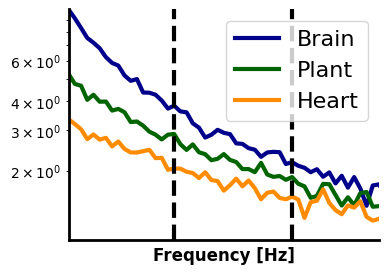

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Simulate example data for three spectra
frequencies = np.linspace(0, 10, 1000)
Pxx1 = 1 / (frequencies + 0.1) + 0.1 * np.random.normal(size=frequencies.shape)
Pxx2 = 1 / (frequencies + 0.2) + 0.1 * np.random.normal(size=frequencies.shape)
Pxx3 = 1 / (frequencies + 0.3) + 0.1 * np.random.normal(size=frequencies.shape)

# Find peaks for all three spectra
peaks1, _ = find_peaks(Pxx1, height=1e-1)
peaks2, _ = find_peaks(Pxx2, height=1e-1)
peaks3, _ = find_peaks(Pxx3, height=1e-1)

# Align peaks across spectra (common peaks)
aligned_peaks = np.intersect1d(peaks1, np.intersect1d(peaks2, peaks3))

# Plot
plt.figure(figsize=(4, 3))
plt.semilogy(frequencies, Pxx1, color='darkblue', linewidth=3, label='Brain')
plt.semilogy(frequencies, Pxx2, color='darkgreen', linewidth=3, label='Plant')
plt.semilogy(frequencies, Pxx3, color='darkorange', linewidth=3, label='Heart')

# Add vertical lines for aligned peaks
for peak in aligned_peaks:
    plt.axvline(x=frequencies[peak], color='black', linestyle='--', linewidth=3)

# Styling
plt.xlabel('Frequency [Hz]', fontsize=12, fontweight='bold')
#plt.ylabel('Power', fontsize=12)
plt.xlim([0, 0.5])
plt.ylim([1, 10])



# Remove borders and background
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# set left and bottom border more thick
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
#plt.gca().spines['left'].set_visible(False)  # Uncomment to remove left border
#plt.gca().spines['bottom'].set_visible(False)  # Uncomment to remove bottom border
plt.gca().set_facecolor('none')

# Ensure no ticks or tick labels
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tick_params(top=False, right=False, left=False, bottom=False)

# Add legend
plt.legend(loc='upper right', fontsize=16)

# Save the plot as a transparent PNG at 300 dpi
plt.savefig('aligned_spectra.png', dpi=300, transparent=True)

# Display plot
plt.show()


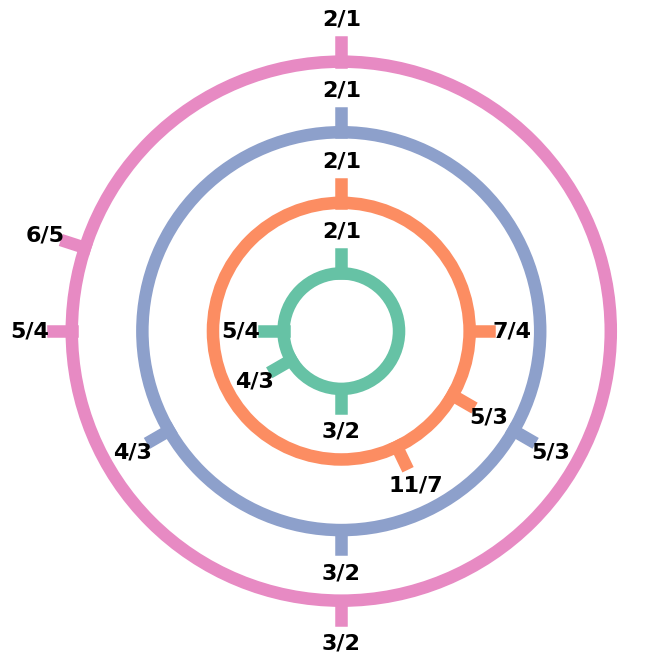

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Define parameters
num_circles = 4
circle_radii = np.linspace(1.5, num_circles * 1.75, num_circles)  # Increase spacing between circles
# take 4 first colors of set 2
colors = plt.cm.Set2.colors[:num_circles]

# Define the ratios for each circle (4 ratios per circle)
ratios_per_circle = [
    [(2, 1), (3, 2), (4, 3), (5, 4)],  # Circle 1
    [(7, 4), (5, 3), (11, 7), (2, 1)],  # Circle 2
    [(3, 2), (5, 3), (2, 1), (4, 3)],  # Circle 3
    [(6, 5), (2, 1), (5, 4), (3, 2)],  # Circle 4
]

# Function to calculate the angle based on the logic of the ratio
def calculate_angle(ratio):
    fraction = ratio[0] / ratio[1] - 1  # Fractional part of the ratio
    return 2 * np.pi * fraction  # Convert fraction to an angle in radians

# Rotate the entire circle by 90 degrees (pi/2 counter-clockwise)
rotation_offset = np.pi / 2

# rotate 180 degrees
rotation_offset = rotation_offset + np.pi

# Create figure and axis for combined plot
fig, ax = plt.subplots(figsize=(8, 8))

# Generate and plot concentric circles with logical ratio positions
for i, radius in enumerate(circle_radii):
    ratios = ratios_per_circle[i]  # Get the ratios for the current circle
    for ratio in ratios:
        angle = calculate_angle(ratio) - rotation_offset  # Apply the rotation

        # Each line spans only the current circle radius
        x = [radius * np.cos(angle), (radius + 0.5) * np.cos(angle)]
        y = [radius * np.sin(angle), (radius + 0.5) * np.sin(angle)]
        ax.plot(x, y, color=colors[i], linewidth=9)  # Increased line thickness

        # Add the ratio label next to the line in fraction format
        ratio_x = (radius + 1.1) * np.cos(angle)
        ratio_y = (radius + 1.1) * np.sin(angle)
        ax.text(
            ratio_x, ratio_y, f"{ratio[0]}/{ratio[1]}", fontsize=16, color="black", ha="center", va="center", fontweight='bold'
        )

    # Draw the circle outline with increased thickness
    circle = plt.Circle((0, 0), radius, color=colors[i], fill=False, linewidth=9, alpha=1)
    ax.add_artist(circle)

# Adjust plot appearance for combined plot
ax.set_aspect("equal", "box")
ax.axis("off")
ax.set_xlim(-circle_radii[-1] - 1, circle_radii[-1] + 1)
ax.set_ylim(-circle_radii[-1] - 1, circle_radii[-1] + 1)
# remove background
ax.set_facecolor('none')
# ensure to have transparent background
fig.patch.set_alpha(0.0)


# save the plot in 300 dpi
plt.savefig('concentric_circles.png', dpi=300)


# Show combined plot
plt.show()


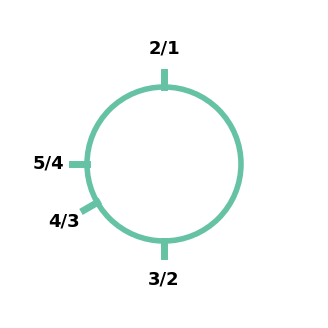

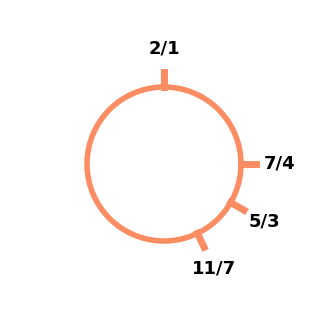

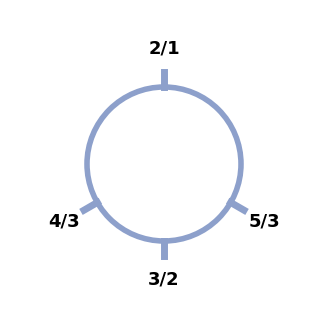

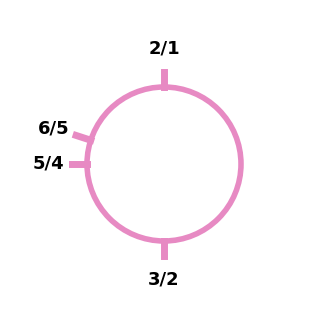

In [72]:
# Create individual plots for each circle
# make circle radii all the same
circle_radii = np.linspace(0.5, 0.5, num_circles)
for i, radius in enumerate(circle_radii):
    fig, ax = plt.subplots(figsize=(4, 4))
    ratios = ratios_per_circle[i]  # Get the ratios for the current circle
    for ratio in ratios:
        angle = calculate_angle(ratio) - rotation_offset  # Calculate the angle for the ratio

        # Each line spans only the current circle radius
        x = [radius * np.cos(angle), (radius + 0.1) * np.cos(angle)]
        y = [radius * np.sin(angle), (radius + 0.1) * np.sin(angle)]
        ax.plot(x, y, color=colors[i], linewidth=5)  # Increased line thickness

        # Add the ratio label next to the line in fraction format
        ratio_x = (radius + 0.25) * np.cos(angle)
        ratio_y = (radius + 0.25) * np.sin(angle)
        ax.text(
            ratio_x, ratio_y, f"{ratio[0]}/{ratio[1]}", fontsize=13, color="black", ha="center", va="center", fontweight='bold'
        )

    # Draw the circle outline with increased thickness
    circle = plt.Circle((0, 0), radius, color=colors[i], fill=False, linewidth=4, alpha=1)
    ax.add_artist(circle)

    # Adjust plot appearance for individual circle
    ax.set_aspect("equal", "box")
    ax.axis("off")
    ax.set_xlim(-circle_radii[-1] - 0.5, circle_radii[-1] + 0.5)  # Use the largest circle's size for consistency
    ax.set_ylim(-circle_radii[-1] - 0.5, circle_radii[-1] + 0.5)

    # remove background
    ax.set_facecolor('none')
    # ensure to have transparent background
    fig.patch.set_alpha(0.0)
    
    # save the plot in 300 dpi
    plt.savefig(f'concentric_circle_{i+1}.png', dpi=300)
    # Show individual circle plot
    plt.show()